In [5]:
import pandas as pd
import numpy as np

df_0 = pd.read_csv(u"datos_limpios/2010.csv")
df_1 = pd.read_csv(u"datos_limpios/2011.csv")
df_2 = pd.read_csv(u"datos_limpios/2012.csv")
df_3 = pd.read_csv(u"datos_limpios/2013.csv")
df_4 = pd.read_csv(u"datos_limpios/2014.csv")
df_5 = pd.read_csv(u"datos_limpios/2015.csv")
df_6 = pd.read_csv(u"datos_limpios/2016.csv")

In [23]:
df_0to6 = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6])
df_0to6 = df_0to6.reset_index(drop=True)

In [24]:
# Selección de columnas
sub_df_0to6 = df_0to6[["GEN_ALU",
               'cat_periodo',
               'anio_ing_carr_ori',
               'anio_ing_carr_act',
               "rango_edad", 
               "tipo_inst_3", 
               "jornada", 
               "tipo_plan_carr", 
               "dur_estudio_carr", 
               "nivel_carrera_1", 
               "nivel_global", 
               "oecd_area", 
               "acreditada_carr", 
               "acreditada_inst"]]

# Restricción a solo datos de pregrado
sub_df_0to6 = (sub_df_0to6.query("nivel_global=='Pregrado' or nivel_global.isnull()")
                         .drop(columns = ['nivel_global'])
                         .dropna(subset=['anio_ing_carr_act']))

sub_df_0to6['anio_en_carr_actual'] = sub_df_0to6['anio_ing_carr_act'] - sub_df_0to6['cat_periodo']

# se pide que cat_periodo == anio_ing_carr_act para no contar a una misma persona todos los años
sub_df_0to6['Class'] = sub_df_0to6.apply(lambda row: row.cat_periodo != row.anio_ing_carr_ori and row.cat_periodo == row.anio_ing_carr_act, axis = 1)
sub_df_0to6 = sub_df_0to6.drop(columns = ['anio_ing_carr_ori', 'cat_periodo', 'anio_ing_carr_act'])

sub_df_0to6['acreditada_carr'] = sub_df_0to6['acreditada_carr'].replace('NO ACREDITADA', False, regex=True)
sub_df_0to6['acreditada_carr'] = sub_df_0to6['acreditada_carr'].replace('ACREDITADA', True, regex=True)
sub_df_0to6['acreditada_inst'] = sub_df_0to6['acreditada_inst'].replace('NO ACREDITADA', False, regex=True)
sub_df_0to6['acreditada_inst'] = sub_df_0to6['acreditada_inst'].replace('ACREDITADA', True, regex=True)

In [25]:
# Se obtienen los tipos de cada columa en un dataframe
sub_df_0to6_datatypes = (pd.DataFrame(sub_df_0to6.dtypes)
                    .reset_index()
                    .rename(columns = {0:'tipo', 'index' : 'columna'})
                    )

# para cada columna...
cols_name = list(sub_df_0to6).remove('GEN_ALU')
df_sub_one_hot = pd.get_dummies(sub_df_0to6[['GEN_ALU']], prefix='GEN_ALU')
for i in range(1, len(sub_df_0to6_datatypes)):
    col_name = sub_df_0to6_datatypes.iloc[i][0]
    
    # Si es que es de tipo object...
    if str(sub_df_0to6_datatypes.iloc[i][1]) == 'object':
        # se le aplica la transformación One Hot
        df_one_hot = pd.get_dummies(sub_df_0to6[[col_name]], prefix=col_name)
    else:
        df_one_hot = sub_df_0to6[[col_name]]
    df_sub_one_hot = pd.merge(df_sub_one_hot, df_one_hot, left_index=True, right_index=True)

df_sub_one_hot = df_sub_one_hot.reset_index(drop=True)

<AxesSubplot:>

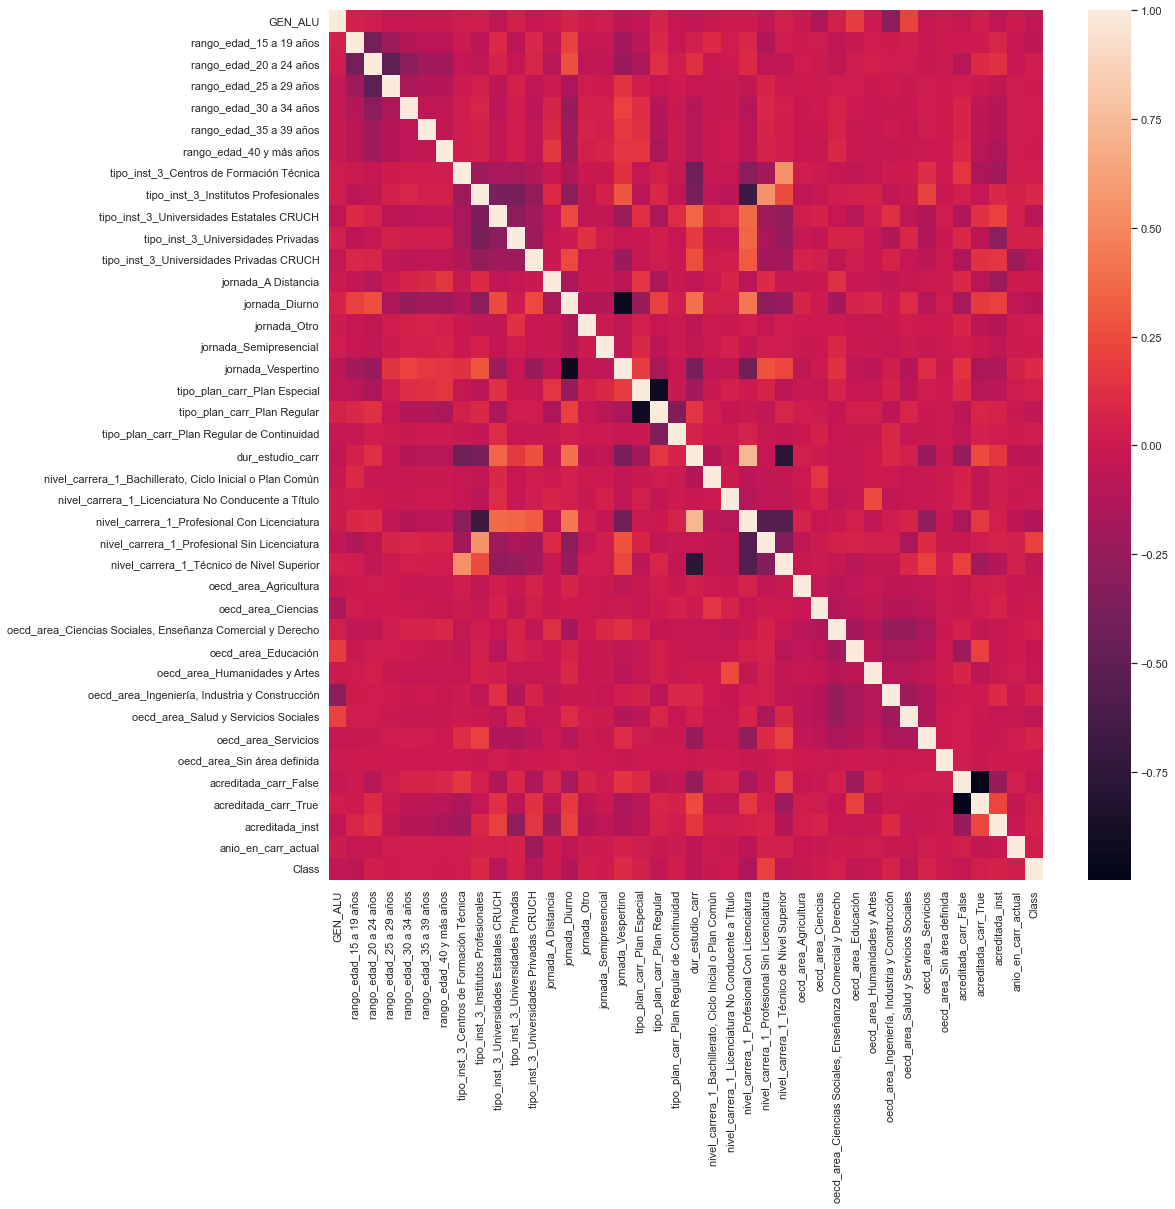

In [26]:
import seaborn

# Se aplica One Hot
corr_sub = df_sub_one_hot.corr()
seaborn.set(rc={'figure.figsize':(16,16)})
seaborn.heatmap(corr_sub)

In [27]:
# se eliminan columnas con correlación alta
df_sub_one_hot = df_sub_one_hot.drop(columns = ['tipo_plan_carr_Plan Regular', 'jornada_Diurno', 'acreditada_carr_False']).dropna()

Se entrenan los clasificadores para solo un año, considerando la cantidad de datos que contiene el dataframe con todos los años.

Se observa que *SVM* y *KNN* presentan malas métricas, en particular el *recall* relacionado a la clase verdadera, además, *SVM* utiliza muchos recursos para tan pocos datos, por lo que se descartan para entrenar con todos los datos. A partir de aquí se entrenan con todos los datos desde el año 2010 hasta el 2016.

In [28]:
from sklearn.model_selection import train_test_split

data_train, data_test, ytrain, ytest = train_test_split(df_sub_one_hot, df_sub_one_hot['Class'], test_size=0.7, stratify=df_sub_one_hot['Class'])
diferencia = ytrain.value_counts()[False]-ytrain.value_counts()[True]
data_train = data_train.reset_index(drop=True)

# oversampling sobre la clase True
idx = np.random.choice(data_train[data_train['Class'] == True].index, size=diferencia)
data_oversampled = pd.concat([data_train, data_train.iloc[idx]])
print("Data oversampled on class 'True'")
print(data_oversampled['Class'].value_counts())

# subsampling sobre la clase False
idx = np.random.choice(data_train.loc[data_train.Class == False].index, size=diferencia, replace=False)
data_subsampled = data_train.drop(data_train.iloc[idx].index)
print("Data subsampled on class 'False'")
print(data_subsampled['Class'].value_counts())

Data oversampled on class 'True'
True     485380
False    485380
Name: Class, dtype: int64
Data subsampled on class 'False'
True     48616
False    48616
Name: Class, dtype: int64


In [29]:
from sklearn.metrics import classification_report

# datos test (mismo para todos los conjuntos de entrenamiento)
X_test = data_test[data_train.columns[:-1]]
y_test = data_test[data_train.columns[-1]]

# datos entrenamiento "originales"
X_orig = data_train[data_train.columns[:-1]] 
y_orig = data_train[data_train.columns[-1]] 

# datos entrenamiento "oversampleados" 
X_over = data_oversampled[data_train.columns[:-1]]
y_over = data_oversampled[data_train.columns[-1]]

# datos entrenamiento "subsampleados"
X_subs = data_subsampled[data_train.columns[:-1]]
y_subs = data_subsampled[data_train.columns[-1]]

In [30]:
from sklearn.tree import DecisionTreeClassifier

print("ORIGINAL::::::::::")
clf_orig = DecisionTreeClassifier()
clf_orig.fit(X_orig, y_orig)
pred_orig = clf_orig.predict(X_test)
print(classification_report(y_test, pred_orig))

print("OVERSAMPLING::::::::::")
clf_over = DecisionTreeClassifier()
clf_over.fit(X_over, y_over)
pred_over = clf_over.predict(X_test)
print(classification_report(y_test, pred_over))

print("SUBSAMPLING::::::::::")
clf_subs = DecisionTreeClassifier()
clf_subs.fit(X_subs, y_subs)
pred_subs = clf_subs.predict(X_test)
print(classification_report(y_test, pred_subs))

ORIGINAL::::::::::
              precision    recall  f1-score   support

       False       0.97      0.99      0.98   1132557
        True       0.83      0.73      0.78    113436

    accuracy                           0.96   1245993
   macro avg       0.90      0.86      0.88   1245993
weighted avg       0.96      0.96      0.96   1245993

OVERSAMPLING::::::::::
              precision    recall  f1-score   support

       False       0.99      0.92      0.95   1132557
        True       0.54      0.94      0.68    113436

    accuracy                           0.92   1245993
   macro avg       0.77      0.93      0.82   1245993
weighted avg       0.95      0.92      0.93   1245993

SUBSAMPLING::::::::::
              precision    recall  f1-score   support

       False       0.99      0.92      0.95   1132557
        True       0.53      0.94      0.68    113436

    accuracy                           0.92   1245993
   macro avg       0.76      0.93      0.82   1245993
weighted a

In [31]:
from sklearn.naive_bayes import GaussianNB  # Naive bayes

print("ORIGINAL::::::::::")
clf_orig_GaussianNB = GaussianNB()
clf_orig_GaussianNB.fit(X_orig, y_orig)
pred_orig_GaussianNB = clf_orig_GaussianNB.predict(X_test)
print(classification_report(y_test, pred_orig_GaussianNB))

print("OVERSAMPLING::::::::::")
clf_over_GaussianNB = GaussianNB()
clf_over_GaussianNB.fit(X_over, y_over)
pred_over_GaussianNB = clf_over_GaussianNB.predict(X_test)
print(classification_report(y_test, pred_over_GaussianNB))

print("SUBSAMPLING::::::::::")
clf_subs_GaussianNB = GaussianNB()
clf_subs_GaussianNB.fit(X_subs, y_subs)
pred_subs_GaussianNB = clf_subs_GaussianNB.predict(X_test)
print(classification_report(y_test, pred_subs_GaussianNB))

ORIGINAL::::::::::
              precision    recall  f1-score   support

       False       0.99      0.79      0.88   1132557
        True       0.31      0.95      0.47    113436

    accuracy                           0.81   1245993
   macro avg       0.65      0.87      0.68   1245993
weighted avg       0.93      0.81      0.84   1245993

OVERSAMPLING::::::::::
              precision    recall  f1-score   support

       False       1.00      0.78      0.88   1132557
        True       0.31      0.96      0.46    113436

    accuracy                           0.80   1245993
   macro avg       0.65      0.87      0.67   1245993
weighted avg       0.93      0.80      0.84   1245993

SUBSAMPLING::::::::::
              precision    recall  f1-score   support

       False       1.00      0.78      0.88   1132557
        True       0.31      0.96      0.47    113436

    accuracy                           0.80   1245993
   macro avg       0.65      0.87      0.67   1245993
weighted a

Finalmente se observa que el clasificador Árbol de Decisión presenta mejores metricas, pues si bien Naive Bayes tiene un recall de $0.96$ presenta, a su vez, una precisión demasiado baja, de $0.31$. Así, el mejor clasificador encontrado es el **Árbol de Decisión** con **Oversampling**, con métricas sobre $0.9$ para la clase negativa y con precisión $0.54$, f1-score de $0.68$ y recall de $0.94$, lo que nos afirma su eficiencia.

Así, hemos obtenido un clasificador capaz de identicar a personas que se cambiarán de carrera, de modo que se pueden implementar medidas para prevenir dicha situación y, de esta manera, ayudar al futuro de los estudiantes.